In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import datasets as ds
from collections import Counter

from scripts import data
from scripts.naive_bayes import from_scratch as naive_bayes
from scripts.naive_bayes import scikit_learn as sk_naive_bayes

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


# The dataset

### Question 1
How many splits does the dataset has?

In [2]:
splits: list[str] = ds.get_dataset_split_names('imdb')
print('Splits:')
for split in splits:
    print(f'\'{split}\'')
print(f'Number of splits: {len(splits)}')

Splits:
'train'
'test'
'unsupervised'
Number of splits: 3


There are 3 splits in the IMDB dataset.

### Question 2
How big are these splits?

In [3]:
datasets: list[ds.Dataset] = data.load_datasets(splits=splits)
print('Dataset sizes:')
for i, dataset in enumerate(datasets):
    print(f'\'{splits[i]}\' split size : {dataset.num_rows}')

Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


Dataset sizes:
'train' split size : 25000
'test' split size : 25000
'unsupervised' split size : 50000


### Question 3
What is the proportion of each class on the supervised splits?

In [4]:
# Get only supervised datasets
supervised_datasets: list[pd.DataFrame] = data.datasets_to_dataframes(datasets[0:2])

print('Supervised dataset sizes:')
# For each dataset, print the number of samples for each class
for i, dataset in enumerate(supervised_datasets):
    print('\n')
    print(f'\'{splits[i]}\'')
    print('Class 0')
    print(dataset.where(dataset['label'] == 0).count())
    print('Class 1')
    print(dataset.where(dataset['label'] == 1).count())

Supervised dataset sizes:


'train'
Class 0
text     12500
label    12500
dtype: int64
Class 1
text     12500
label    12500
dtype: int64


'test'
Class 0
text     12500
label    12500
dtype: int64
Class 1
text     12500
label    12500
dtype: int64


Hence, each class represents 50% of the supervised dataset (both in train and test samples).

# Naive Bayes classifier 

### Question 1

#### Preprocessing

In [5]:
# Assert whether the the preprocessing gives the expected result (e.g. "Hello, ,,,World!::" -> "hello world")
data.test_preprocessing("Hello, ,,,World!::", "hello world")
data.test_preprocessing("Hello,        U.S.A!", "hello u.s.a")

Now let's apply the preprocessing to train and test sets (supervised datasets). 

In [6]:
train_df, test_df = data.processed_dataframes(supervised_datasets)

# Convert labels to int in the dataframes
train_df.label = train_df.label.astype(int)
test_df.label = test_df.label.astype(int)

# Train dataset preview
train_df.head()

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,text,label
0,i rented i am curious-yellow from my video sto...,0
1,i am curious yellow is a risible and pretentio...,0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godard's ma...,0
4,oh brotherafter hearing about this ridiculous ...,0


### Question 2

Let's build the vocabulary of the training set.

In [7]:
# The Counter collection is used to build up the vocabulary, and store with it the number of occurrences of each word
vocabulary: Counter = naive_bayes.build_vocabulary(texts_serie=train_df.text)
counter_class: pd.DataFrame = train_df.groupby("label").agg({'text': naive_bayes.build_vocabulary})

### Naive Bayes classifier pseudo-code

<img src="./nbc.png" width="30%" height="20%">

### 'From scratch' Naive Bayes classifier

#### Train Naive Bayes model

The set of variables `logprior, loglikelihood` represent the naive bayes model.

In [8]:
logprior, loglikelihood = naive_bayes.classifier(train_df, vocabulary, counter_class)

#### Predictions
Make prediction on each text of the training and testing sets and store them in a `'model_result'` column in the pandas dataframe.

In [9]:
# Mapping lambda function to apply to each row of the dataframe
test_classifier = lambda text : naive_bayes.test_classifier(text, logprior, loglikelihood, train_df, vocabulary)

train_df["model_result"] = train_df.text.apply(test_classifier)
test_df["model_result"] = test_df.text.apply(test_classifier)

### Question 4 ('From scratch' implementation)

#### Results
We are now able to get the good predictions count, hence we can get an accuracy ratio.

In [10]:
naive_bayes.display_accuracy(train_df, "Train")
naive_bayes.display_accuracy(test_df, "Test")

Train accuracy: 89.83%
Test accuracy: 81.10%


### Question 3

In [11]:
pipeline = sk_naive_bayes.pipeline()

# Train the model on the training set
pipeline.fit(train_df.text, train_df.label)

# Make predictions on the train and test sets
train_predictions = pipeline.predict(train_df.text)
test_predictions = pipeline.predict(test_df.text)

### Question 4 (scikit-learn implementation)

In [12]:
# Print the classificiation report
print('Classification report (testing):')
sk_naive_bayes.print_classification_report(test_df, test_predictions)

# Print the confusion matrix
print('Confusion matrix (testing):')
sk_naive_bayes.print_confusion_matrix(test_df, test_predictions)
print('\n')

# Print the accuracy score (training)
_ = sk_naive_bayes.get_accuracy_score(train_df, train_predictions, 'Training')
# Print the accuracy score (testing)
_ = sk_naive_bayes.get_accuracy_score(test_df, test_predictions, 'Testing')

Classification report (testing):
              precision    recall  f1-score   support

           0       0.78      0.88      0.83     12500
           1       0.86      0.76      0.80     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

Confusion matrix (testing):
[[10969  1531]
 [ 3051  9449]]


Training accuracy: 90.32%
Testing accuracy: 81.67%


### Question 5

Looking at the documentation of the `CountVectorizer` class, we understand that the internal implementation produces a sparse matrix using `scipy`. In some cases, sparse data can be considered as a form of regularization, limiting the number of features the model can use in order to make a predictions.
In other terms, sparse data may help to avoid (or at least reduce) overfitting.

### Question 6

The accuracy metrics is a sufficient metric to measure the performance of our model. Indeed, the dataset is equally distributed between the classes and are well separated between positive and negative sentiments.

### Question 7
Here, we are taking three wrongly classified samples of our tests set and we takes result of Naive Bayes Classifier from scratch (vocabulary, loglikelihood).

In [13]:
# Take a text which is wrongly classified
failed = test_df[test_df['label'] != test_df['model_result']].iloc[25:28]

# Tokenize
for item in failed.iloc:
    text = item.text
    word_list = naive_bayes.tokenize(text)
    counter = 0
    total_word_count = len(word_list)
    best_like = 0
    best_log = None
    best_word = None
    for word in word_list:
        if(vocabulary[word]!=0):
            if (best_log is None or best_log < loglikelihood[word][item.label]):
                best_log = loglikelihood[word][item.label]
                best_word = word 
    print(f'{best_log = }, {best_word = }, Label = {item.label}, model_result = {item.model_result}, {loglikelihood[best_word] = }')

best_log = -2.8908622614401334, best_word = 'the', Label = 0, model_result = 1, loglikelihood[best_word] = {0: -2.8908622614401334, 1: -2.8546730645815397}
best_log = -2.8908622614401334, best_word = 'the', Label = 0, model_result = 1, loglikelihood[best_word] = {0: -2.8908622614401334, 1: -2.8546730645815397}
best_log = -2.8908622614401334, best_word = 'the', Label = 0, model_result = 1, loglikelihood[best_word] = {0: -2.8908622614401334, 1: -2.8546730645815397}


The model failed because a text is composed of many neutral word such as 'the' or 'and'. But the NBC can influence the result label because neutral words do not have the same loglikelihood for each class. The example above shows that for each text the word 'the' has the best loglikelihood for class '1' which can influence the class result of the NBC even if the word 'the' is neither positive nor negative. So if a frequently used and neutral word such as 'the' can influence the result it is possible that other word can do so.

### Question 8

#### i - Highest likelihood

Look at the words with the highest likelihood in each class (if you use scikit-learn, you want to check feature_log_prob_).

In [14]:
# Print the most likely words
sk_naive_bayes.print_most_likely_words(pipeline)

Class:  0
Most likely words:  ['was', 'that', 'this', 'in', 'it', 'is', 'to', 'of', 'and', 'the']

Class:  1
Most likely words:  ['as', 'this', 'that', 'it', 'in', 'is', 'to', 'of', 'and', 'the']



#### ii - Stopwords removal

##### Download stopwords

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francois.soulier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### Training and testing

In [16]:
stop_words: list[str] = data.get_stopwords()
pipeline = sk_naive_bayes.pipeline(stop_words=stop_words)

# Train the model on the training set
pipeline.fit(train_df.text, train_df.label)

# Make predictions on the train and test sets
train_predictions = pipeline.predict(train_df.text)
test_predictions = pipeline.predict(test_df.text)

# Print the accuracy score (training)
_ = sk_naive_bayes.get_accuracy_score(train_df, train_predictions, 'Training')
# Print the accuracy score (testing)
_ = sk_naive_bayes.get_accuracy_score(test_df, test_predictions, 'Testing')

Training accuracy: 91.91%
Testing accuracy: 82.74%


### $\alpha$ hyperparameter tuning

The idea is to test different values of $\alpha$ and to keep the one that gives the best accuracy on the test set.

In [17]:
train_vals = []
test_vals = []
# Take a range of values for alpha
alphas: np.ndarray = np.arange(0, 100, 5)
stop_words: list[str] = data.get_stopwords()

for alpha in alphas:
    pipeline = sk_naive_bayes.pipeline(stop_words=stop_words, alpha=alpha)

    # Train the model on the training set
    pipeline.fit(train_df.text, train_df.label)

    # Make predictions on the train and test sets
    train_predictions = pipeline.predict(train_df.text)
    test_predictions = pipeline.predict(test_df.text)

    # Print the accuracy score (training)
    train_val = sk_naive_bayes.get_accuracy_score(train_df, train_predictions, 'Training', print_results=False)
    # Print the accuracy score (testing)
    test_val = sk_naive_bayes.get_accuracy_score(test_df, test_predictions, 'Testing', print_results=False)

    train_vals.append(train_val)
    test_vals.append(test_val)

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


Plot the accuracy on the test set for each value of $\alpha$.

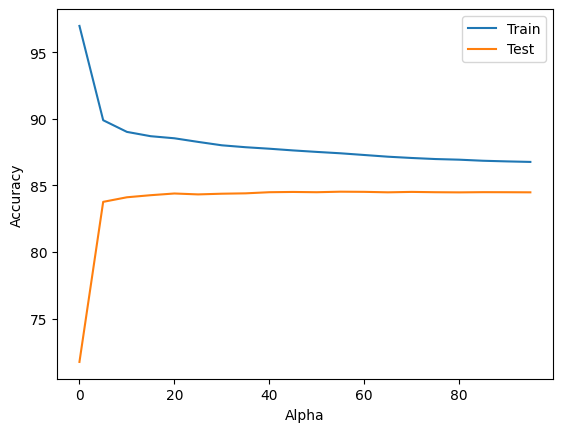

In [18]:
plt.plot(alphas, train_vals, label='Train')
plt.plot(alphas, test_vals, label='Test')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

According to the results, the best value for $\alpha$ is around 55 (with a step of 5 for a range from 0 to 100). The $\alpha$ hyperparameter represents the Laplace smoothing, and can be considered as a form of regularization. Hence, in particular cases, modifying $\alpha$ can reduce overfitting, as the result is a more robust due to smoothing.

# Stemming and Lemmatization

### Question 1

#### Download wordnet

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/francois.soulier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The new preprocessing function is implemented in './scripts/naive_bayes/scikit_learn.py'. The text preprocessing now includes lemmatization.

### Question 2

Get supervised data and apply preprocessing.

In [20]:
train_df, test_df = data.get_train_test_sets(dataframes=supervised_datasets)

train_df.text = train_df.text.apply(data.preprocess_with_lemmatizer)
test_df.text = test_df.text.apply(data.preprocess_with_lemmatizer)

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Training

In [21]:
pipeline = sk_naive_bayes.pipeline(stop_words=stop_words)

# Train the model on the training set
pipeline = pipeline.fit(train_df.text, train_df.label)

Testing

In [22]:
# Make predictions on the train and test sets
train_predictions = pipeline.predict(train_df.text)
test_predictions = pipeline.predict(test_df.text)

# Print the accuracy score (training)
_ = sk_naive_bayes.get_accuracy_score(train_df, train_predictions, 'Training')
# Print the accuracy score (testing)
_ = sk_naive_bayes.get_accuracy_score(test_df, test_predictions, 'Testing')

Training accuracy: 91.53%
Testing accuracy: 82.37%


We observe that the accuracy is slightly worse than the previous model.

### Question 3

The results with lemmatization are sligthly worse than with the previous preprocessing method (0.38% loss in train accuracy and 0.37% loss in test accuracy). This can be the result of several factors:
* There can be some ambiguity in the lemmatization process. For instance, if we lemmatize the word 'left' into 'leave', we can lose some information about the direction in the sentence. In the case of sentiment analysis, such an ambiguity can cause wrong predictions.
* The lemmatization process in English can sometimes result in over-stemming. As an example, the words 'fishing' and 'fish' have the same lemma: 'fish'. In some cases, the loss of distinction between words can decrease the accuracy of the model.

However, lemmatization may not always affect the accuracy of the model. Here, the accuracy only dropped by ~0.4% on both the train and test sets. This can be explained by the fact that the dataset is relatively small and that the lemmatization process is not too impactful.